268115
268114


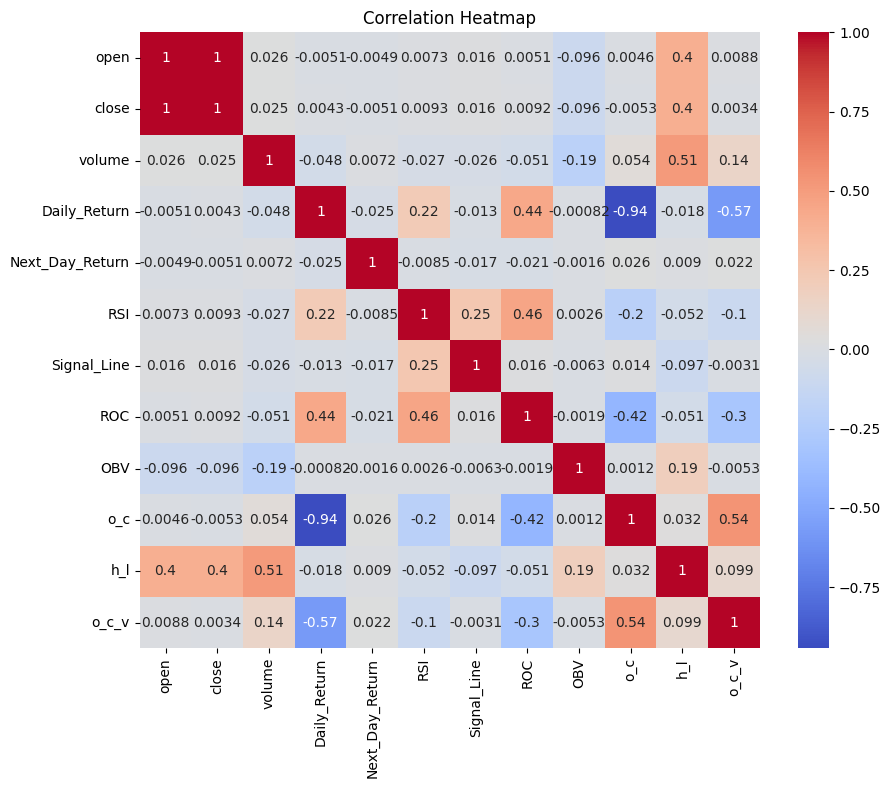

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)

def get_data(timeframe):
    return read_file("../../data/btcusdt_" + timeframe + "_train.csv")

time_frame = "5m"
# Load data
k = 1
df = get_data(time_frame)
df.head()
df['Daily_Return'] = df['close'].pct_change()
df['Next_Day_Return'] = df['close'].pct_change(k).shift(-k)
df.fillna(0, inplace=True)
window = 14
delta = df['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
short_window = 12
long_window = 26
signal_window = 9
df['Short_MA'] = df['close'].rolling(window=short_window).mean()
df['Long_MA'] = df['close'].rolling(window=long_window).mean()
df['MACD'] = df['Short_MA'] - df['Long_MA']
df['Signal_Line'] = df['MACD'].rolling(window=signal_window).mean()
n = 5
df['ROC'] = df['close'].pct_change(n) * 100
df['OBV'] = np.where(df['close'] > df['close'].shift(1), df['volume'], -df['volume'])
df['OBV'] = df['OBV'].cumsum()
df['o_c'] = df['open'] - df['close']
df['h_l'] = df['high'] - df['low']
df['o_c_v'] = df['o_c']*df['volume']
# df['dr_v'] = df['Daily_Return']*df['volume']
# df['dr/v'] = df['Daily_Return']/df['volume']
df_ = df.drop(['high', 'low', 'MACD', 'Short_MA', 'Long_MA'], axis=1)
df_ = df_.drop(df_.index[:50])
print(len(df_))
df_ = df_.dropna()
print(len(df_))

# Calculate the correlation matrix
correlation_matrix = df_.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
df_.to_csv("../logs/junk" + time_frame + ".csv")

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

print(df_.shape)
df_train, df_val = train_test_split(df_, test_size=0.2, shuffle=False)
print(df_train.shape, df_val.shape)

# Create the linear regression model
model = LinearRegression()
# Define the independent variables
X_train = df_train.drop('Next_Day_Return', axis=1)
X_train = X_train.drop('open', axis=1)
X_val = df_val.drop('Next_Day_Return', axis=1)
X_val = X_val.drop('open', axis=1)
# Define the dependent variable
y_train = df_train['Next_Day_Return']
y_val = df_val['Next_Day_Return']
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

df_train['indicator'] = 0
df_val['indicator'] = 0
# Fit the linear regression model on the training data
X_train.head()

(268114, 12)
(214491, 12) (53623, 12)
(214491, 10) (214491,)
(53623, 10) (53623,)


,close,volume,Daily_Return,RSI,Signal_Line,ROC,OBV,o_c,h_l,o_c_v
datetime,,,,,,,,,,
2018-01-01 09:40:00,13351.71,32.528288,-0.003604,54.324571,67.078497,-1.024836,-179.183478,48.28,105.33,1570.465745
2018-01-01 09:45:00,13330.05,36.474570,-0.001622,48.449522,72.490605,-0.788405,-215.658048,24.94,66.43,909.675776
2018-01-01 09:50:00,13408.99,17.610242,0.005922,47.130560,74.297678,-0.007755,-198.047806,-72.01,79.00,-1268.113526
2018-01-01 09:55:00,13430.00,16.478325,0.001567,47.790564,72.612650,0.022716,-181.569481,-21.01,58.58,-346.209608
2018-01-01 10:00:00,13445.35,24.084508,0.001143,44.600351,67.715670,0.338433,-157.484973,-15.36,58.96,-369.938043


In [23]:

model.fit(X_train, y_train)

# Predict the dependent variable of the training data
y_pred = model.predict(X_train)
df_train['indicator'] = 2*(y_pred > 0).astype(int) - 1
data = df_train
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0

data['signal'] = data['signal'].shift(1)
data.at[data.index[0], 'signal'] = 0
data.to_csv("../logs/lin_reg_train_" + time_frame + ".csv")

# Predict the dependent variable of the validation data
y_pred = model.predict(X_val)
df_val['indicator'] = 2*(y_pred > 0).astype(int) - 1
data = df_val
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0
# data['signal'] = data['signal'].shift(1)
data.at[data.index[0], 'signal'] = 0
data.to_csv("../logs/lin_reg_val_" + time_frame + ".csv")

In [24]:
print(model.coef_, model.intercept_)

[-9.79075667e-09  1.96344728e-08 -2.39646106e-02  1.19781046e-06
 -1.40131525e-06 -3.22235082e-05 -5.26717924e-11 -1.50532065e-06
  7.58246646e-07  3.06808169e-09] -2.3780883125615116e-05


In [4]:
y_pred = pd.Series(y_pred)
data['y_pred'] = y_pred.values
# data.pivot_table(index = pd.qcut(data['Next_Day_Return'],10,duplicates='drop'), values=['y_pred'], aggfunc = ['mean', 'median', 'count'])
count_zero = data[data['y_pred'] < 1e-9]['y_pred'].count()
print(count_zero)

5129
